In [3]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(12)

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path, )

# data = candel.pvdata.load_SH0ES("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")

2025-07-01 11:09:22 warning: zero width found in the priors. Setting it to 1e-5.
2025-07-01 11:09:22 indices of zero width: [44]
2025-07-01 11:09:22 found zero-width prior at index 44. Setting it to 0.


In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path, )

model = candel.model.SH0ESModel(config_path, data)

2025-06-30 11:08:20 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-30 11:08:20 indices of zero width: [44]
2025-06-30 11:08:20 found zero-width prior at index 44. Setting it to 0.
2025-06-30 11:08:20 replacing prior of `M_B` with a delta function.
2025-06-30 11:08:20 replacing prior of `A_covmat` with a delta function.
2025-06-30 11:08:20 replacing prior of `beta` with a delta function.
2025-06-30 11:08:20 loading host galaxy LOS interpolators.
2025-06-30 11:08:20 Popped the following keys with `None` values from data: czcmb_SN_HF, e_czcmb_SN_HF, RA_SN_HF, dec_SN_HF
2025-06-30 11:08:20 Converting host RA/dec to Cartesian coordinates.
2025-06-30 11:08:20 set the following attributes: mag_cepheid, logP, OH, C_Cepheid, L_Cepheid, L_Cepheid_host_dist, Cepheids_only, num_cepheids, num_hosts, Y_SN_Cepheid, C_SN_Cepheid, L_SN_Cepheid, L_SN_Cepheid_dist, Y_SN_HF, num_flow_SN, Y_SN, C_SN, L_SN, mu_N4258_anchor, e_mu_N4258_anchor, e2_mu_N4258_anchor, mu_LMC_anchor, e_mu_LMC

In [ ]:
samples = candel.run_SH0ES_inference(model, )

2025-06-26 17:26:23 running inference on devices: cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu)
2025-06-26 17:26:23 using NumPyro platform: CPU


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

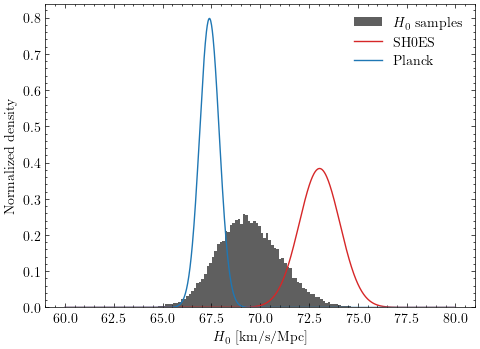

In [4]:
with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(5, 3.7),)

    # Histogram of H0 samples (normalize to max height = 1)
    counts, bins, _ = ax.hist(
        samples["H0"], bins="auto", density=True, alpha=0.9, color="0.3",
        label=r"$H_0$ samples"
    )
    max_density = counts.max()

    # Define a range for the Gaussians
    H0_vals = np.linspace(60, 80, 1000)

    # SH0ES (e.g. Riess+2021), normalized to match
    H0_SH0ES = 73.04
    H0_SH0ES_err = 1.04
    shoes_pdf = norm.pdf(H0_vals, loc=H0_SH0ES, scale=H0_SH0ES_err)
    # shoes_pdf /= shoes_pdf.max()  # normalize peak to 1
    # shoes_pdf *= max_density      # scale to match sample histogram
    ax.plot(H0_vals, shoes_pdf, color="tab:red", label="SH0ES")

    # Planck (e.g. Planck 2018), normalized to match
    H0_Planck = 67.4
    H0_Planck_err = 0.5
    planck_pdf = norm.pdf(H0_vals, loc=H0_Planck, scale=H0_Planck_err)
    # planck_pdf /= planck_pdf.max()
    # planck_pdf *= max_density
    ax.plot(H0_vals, planck_pdf, color="tab:blue", label="Planck")

    ax.set_xlabel(r"$H_0~[\mathrm{km/s/Mpc}]$")
    ax.set_ylabel("Normalized density")
    ax.legend()

    plt.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/H0_samples.png", bbox_inches="tight", dpi=450)
    plt.show()

In [5]:
from scipy.stats import norm
import posterior_agreement

H0_SH0ES = samples["H0"]
# H0_planck = norm(67.4, 0.5).rvs(50000)
H0_planck = norm(73.04, 1.04).rvs(50000)



chains = (H0_SH0ES, H0_planck)
agreement_1d = posterior_agreement.compute_agreement(chains)

print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

p-value 0.016, corresponding to 2.4168 sigmas
